**Práctica realizada por Alvaro Herreruela y Borja Gómez Sopeña**

# Lab assignment: fraud detection through ensemble methods

<img src="img/fraud.jpg" style="width:600px;">

In this assignment we will use all the skills in ensemble learning we acquired from previous exercises to build a an automated fraud detection system.

## Guidelines

The following code will embed any plots into the notebook instead of generating a new window:

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Lastly, if you need any help on the usage of a Python function you can place the writing cursor over its name and press Shift+Tab to produce a pop-out with related documentation. This will only work inside code cells. 

Let's go!

## Data loading

The data for this problem is included in the *data* folder, with separate files for training and test data. Each file includes several unidentified explanatory features, together with an "Amount" feature and the target "Class". Fraudulent operations are marked as Class == 1.

In [2]:
import numpy as np
import pandas as pd

In [3]:
test = pd.read_csv('C:/Users/bgomez/Desktop/Carpetas MDS_F/MDS_F_23_03_2021/Aprendizaje supervisado II/Árboles de decisión y Random forest y otros ensembles - Álvaro Barbero/practica/data/fraud_test.csv', sep = ',')
train = pd.read_csv('C:/Users/bgomez/Desktop/Carpetas MDS_F/MDS_F_23_03_2021/Aprendizaje supervisado II/Árboles de decisión y Random forest y otros ensembles - Álvaro Barbero/practica/data/fraud_train.csv', sep = ',')
#test = pd.read_csv('C:/Users/aherreruela/Downloads/Árboles de decisión y Random forest y otros ensembles - Álvaro Barbero-20210329/afiEnsembles/practica/data/fraud_test.csv', sep = ',')
#train = pd.read_csv('C:/Users/aherreruela/Downloads/Árboles de decisión y Random forest y otros ensembles - Álvaro Barbero-20210329/afiEnsembles/practica/data/fraud_train.csv', sep = ',')

In [4]:
X_train = train.drop('Class', axis = 1)
y_train = train['Class']
X_test = test.drop('Class', axis = 1)
y_test = test['Class']

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
Perform a brief analysis of the training data to answer the following questions: how many explanatory variables do you have? What is the distribution of classes?
 </td></tr>
</table>

**Try to avoid running ProfileReport in the schools' laptops, it requires high computing capabilities and leaves the laptop unusable for a while even after proyecting the results.** (This is the reaon why we have run it last).

In [5]:
#!pip install imblearn

In [1]:
from pandas_profiling import ProfileReport

profile = ProfileReport(train, title="Pandas Profiling Report")

profile.to_notebook_iframe()

In the training datset we have 29 continuous variables and 1 categorical variable, 0 for not fraud, 1 for fraud. Almost all of the variables are normally distributed, although 'variable 26' has a bimodal shape. Also, the variable 'Amount' is a good example of a 'zero inflated variable', as most of its data is zero. 
Moreover, as stated before, the dataset is highly unbalanced, thefore, we'll need to take this into account when defining the hyperparameters.

## Measuring the performance of a fraud detector

Fraudulent activities are usually prosecuted, therefore fraudsters need to be creative and come up constantly with new ways of performing fraud. Furthermore, frauds are scarce (fortunately), and so we have few positive class patterns available for training. This means the problem is highly unbalanced, which is a problem for training good models, but is also a problem for the model evaluation. 

Consider a dumb model that classifies all data as negative (non-fraud). We can simulate the predictions of this model by creating a predictions vector of all zeros:

In [7]:
dumbpreds = [0] * len(test)

Let's measure the accuracy of this model

In [8]:
from sklearn.metrics import accuracy_score

accuracy_score(test["Class"], dumbpreds)

0.9531071292413267

Yo should have obtained a 95% of accuracy, because most of the patterns are indeed negative. But this would be totally useless as a fraud detector! Therefore, we need a better metric.

One that works well for heavily unbalanced problems is the [area under the ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic), or AUC in short. In scikit-learn this metric is readily available, and we can test how this reveals the poor performance of this dumb model

In [9]:
from sklearn.metrics import roc_auc_score

roc_auc_score(test["Class"], dumbpreds)

0.5

An AUC of 50% means the model is no better than a random guess. We should aim to maximize this metric and attain a 100%, meaning all fraudulent patterns obtain higher scores than non-fraud patterns.

## Unsupervised fraud detector

Since we now we have scarce positive data, it might make sense to start building an unsupervised fraud detector.

As the variables' units are very different from one another, we proceed with the escalation of the variables so that none of them has higher importance over the others. This only worse with continuous variables.

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

After escaling the variables, we train the Isolation Forest ensemble with a contamination hiperparater. This a a usefull tool for telling our model what is the proportion of fraudulent transactions in our dataset.

In [11]:
from sklearn.ensemble import IsolationForest
import seaborn as sns

In [12]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn import datasets, metrics, model_selection, svm

In [13]:
# Inicialización del modelo
clf = IsolationForest(random_state=42, contamination = len(train[train['Class'] == 1])/len(train))
clf.fit(X_train, y_train)
preds = clf.predict(X_test)

We can observe that the area under the curve is very small, therefore we turn the model predictions arround and we obtain a very good AUC.

In [14]:
# Area under the curve
preds_scores = clf.score_samples(X_test)
preds = preds * -1
AUC_clf = roc_auc_score(y_test, preds_scores)
print('Area under the curve for the Isolation Forest:', AUC_clf)

Area under the curve for the Isolation Forest: 0.05647073170731707


Once the prediction is made, we are going to negate it as the ones represent fraud and the -ones should be the ones representing atipic values. Now the AUC improves quite a lot.

In [15]:
# Multiplicando por -1 le damos la vuelta al modelo y nos sale un métrica cojonuda
fpr, tpr, thresholds = roc_curve(y_test,preds_scores*-1)

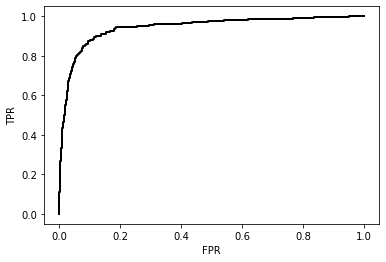

In [16]:
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, 'k-', lw=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
#plt.legend(loc='lower right')
plt.show()

**This is an example of a very imbalanced dataset, therefore some transformations/adaptations have to be made. We'll start by making a farud transaction be 20 times worse than a non-fraudulent transaction.**

En ML hay varias maneras de modificar el dataset para reducir el impacto que tiene el desbalanceo entre clases a la hora de predecir. Los métodos más utilizados son:
- Synthesisis of new minority class instances
- Over-sampling of minority class
- Under-sampling of majority class
- Tweak the cost function to make misclassification of minority instances more important than misclassification of majority instances

**Modificando la función de coste:**

In [17]:
FALSE_NEGATIVE_PENALTY = 20

In [18]:
# Tenemos que convertir los -1 a 0 para poder comparar el accuracy del modelo entre y_test y las preds
preds[preds == -1] = 0

With this, we can define a class-weighted accuracy metric as follows

In [19]:
def weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):
    conf = confusion_matrix(y_test, preds)
    loss = conf[0][1] + conf[1][0] * FALSE_NEGATIVE_PENALTY
    maxloss = conf[0][0] + conf[0][1] + (conf[1][0] + conf[1][1]) * FALSE_NEGATIVE_PENALTY
    return (maxloss - loss) / maxloss * 100

We can test it works as expected with the following toy examples. First, an array of perfect predictions except for a false positive

In [20]:
print(f"Weighted accuracy = {weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):.3}%")

Weighted accuracy = 77.3%


We have found a very good model for predicting false negatives. False Negatives are being penalized x20 times more than False positives. The weighted accuracy represents that this is a compteitive model.

**Comprobación de la efectividad del modelo weighted accuracy:**

In [21]:
# Comprobación de como el modelo castiga los false negatives
y_values = [0, 0, 1, 1]
y_preds =  [0, 1, 1, 1]
print(f"Weighted accuracy = {weighted_accuracy(y_values, y_preds, FALSE_NEGATIVE_PENALTY):.3}%")
y_values = [0, 0, 1, 1]
y_preds =  [0, 0, 0, 1]
print(f"Weighted accuracy = {weighted_accuracy(y_values, y_preds, FALSE_NEGATIVE_PENALTY):.3}%")

Weighted accuracy = 97.6%
Weighted accuracy = 52.4%


As we expected, this metric gives much more weight to mistakes made over patients at risk. We will need to take this into account when creating our model.

In [22]:
arr = np.array([0,1])

In [23]:
# Matriz de confusión
matriz_confusion = confusion_matrix(y_test, preds)

In [24]:
matriz_confusion = pd.DataFrame(matriz_confusion)
matriz_confusion

,0,1
0,4889,111
1,107,139


In [25]:
print('Nuestro modelo a la hora de predecir fraude tiene un error de un ' + str(107/139))

Nuestro modelo a la hora de predecir fraude tiene un error de un 0.7697841726618705


**Modelos con Oversampling:**

In [26]:
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time
import copy

# Classifier Libraries
from sklearn.ensemble import IsolationForest
from sklego.mixture import GMMClassifier, GMMOutlierDetector
import collections


# train/test split libraries and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler

from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline

# libraries to handle imbalanced datasets
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, \
accuracy_score, classification_report, balanced_accuracy_score, cohen_kappa_score, average_precision_score
from collections import Counter

**SMOTE A**: Valores por defecto

In [27]:
# Oversample and plot imbalanced dataset with SMOTE

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from numpy import where

oversample = SMOTE(random_state = 42)
X, y = oversample.fit_resample(X_train, y_train)
counter = Counter(y)
print(counter)

Counter({1: 5000, 0: 5000})


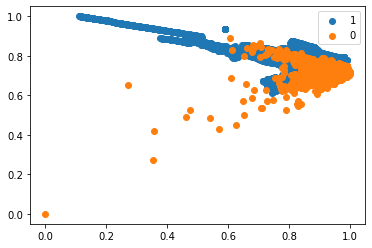

In [28]:
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(y == label)[0]
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

**Construcción y evaluación del modelo SMOTE A:**

Area under the curve for the Isolation Forest: 0.14532113821138212


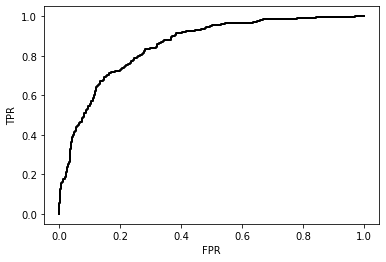

Weighted accuracy = 59.0%


,0,1
0,4893,107
1,198,48


In [29]:
# Inicialización del modelo
clf = IsolationForest(random_state=42)
clf.fit(X, y)
preds = clf.predict(X_test)

# Area under the curve
preds_scores = clf.score_samples(X_test)
preds = preds * -1
AUC_clf = roc_auc_score(y_test, preds_scores)
print('Area under the curve for the Isolation Forest:', AUC_clf)

# Multiplicando por -1 le damos la vuelta al modelo y nos sale un métrica cojonuda
fpr, tpr, thresholds = roc_curve(y_test,preds_scores*-1)

import matplotlib.pyplot as plt
plt.plot(fpr, tpr, 'k-', lw=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
#plt.legend(loc='lower right')
plt.show()

FALSE_NEGATIVE_PENALTY = 20

# Tenemos que convertir los -1 a 0 para poder comparar el accuracy del modelo entre y_test y las preds
preds[preds == -1] = 0

def weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):
    conf = confusion_matrix(y_test, preds)
    loss = conf[0][1] + conf[1][0] * FALSE_NEGATIVE_PENALTY
    maxloss = conf[0][0] + conf[0][1] + (conf[1][0] + conf[1][1]) * FALSE_NEGATIVE_PENALTY
    return (maxloss - loss) / maxloss * 100

print(f"Weighted accuracy = {weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):.3}%")

arr = np.array([0,1])

# Matriz de confusión
matriz_confusion = confusion_matrix(y_test, preds)

matriz_confusion = pd.DataFrame(matriz_confusion)
matriz_confusion

**SMOTE B**: Undersampling de clase 0 y oversampling de clase 1

In [30]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [31]:
# summarize class distribution
counter = Counter(y_train)
print(counter)
# define pipeline
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X, y = pipeline.fit_resample(X_train, y_train)
# summarize the new class distribution
counter = Counter(y)
print(counter)

Counter({0: 5000, 1: 246})
Counter({0: 1000, 1: 500})


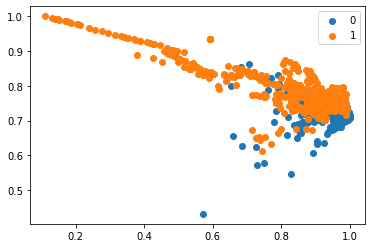

In [32]:
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(y == label)[0]
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

**Construcción y evaluación del modelo SMOTE B:**

In [33]:
# Comprobación modelo SMOTE B:

# Inicialización del modelo
clf = IsolationForest(random_state=42)
clf.fit(X, y)
preds = clf.predict(X_test)

# Area under the curve
preds_scores = clf.score_samples(X_test)
preds = preds * -1
AUC_clf = roc_auc_score(y_test, preds_scores)
print('Area under the curve for the Isolation Forest:', AUC_clf)

# Evaluación del modelo
FALSE_NEGATIVE_PENALTY = 20

## Tenemos que convertir los -1 a 0 para poder comparar el accuracy del modelo entre y_test y las preds
preds[preds == -1] = 0

def weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):
    conf = confusion_matrix(y_test, preds)
    loss = conf[0][1] + conf[1][0] * FALSE_NEGATIVE_PENALTY
    maxloss = conf[0][0] + conf[0][1] + (conf[1][0] + conf[1][1]) * FALSE_NEGATIVE_PENALTY
    return (maxloss - loss) / maxloss * 100

print(f"Weighted accuracy = {weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):.3}%")

# Matriz de confusión
matriz_confusion = confusion_matrix(y_test, preds)
matriz_confusion = pd.DataFrame(matriz_confusion)
matriz_confusion

Area under the curve for the Isolation Forest: 0.12441544715447153
Weighted accuracy = 62.4%


,0,1
0,4931,69
1,183,63


**Borderline SMOTE:**

Counter({0: 5000, 1: 246})
Counter({1: 5000, 0: 5000})


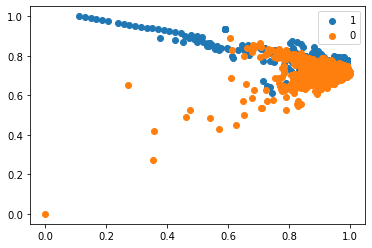

In [34]:
from imblearn.over_sampling import BorderlineSMOTE

# summarize class distribution
counter = Counter(y_train)
print(counter)
oversample = BorderlineSMOTE(random_state = 42)
X, y = oversample.fit_resample(X_train, y_train)
counter = Counter(y)
print(counter)

for label, _ in counter.items():
    row_ix = where(y == label)[0]
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

**Construcción y evaluación del modelo Borderline SMOTE:**

In [35]:
# Comprobación modelo Borderline SMOTE:

# Inicialización del modelo
clf = IsolationForest(random_state=42)
clf.fit(X, y)
preds = clf.predict(X_test)

# Area under the curve
preds_scores = clf.score_samples(X_test)
preds = preds * -1
AUC_clf = roc_auc_score(y_test, preds_scores)
print('Area under the curve for the Isolation Forest:', AUC_clf)

# Evaluación del modelo
FALSE_NEGATIVE_PENALTY = 20

## Tenemos que convertir los -1 a 0 para poder comparar el accuracy del modelo entre y_test y las preds
preds[preds == -1] = 0

def weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):
    conf = confusion_matrix(y_test, preds)
    loss = conf[0][1] + conf[1][0] * FALSE_NEGATIVE_PENALTY
    maxloss = conf[0][0] + conf[0][1] + (conf[1][0] + conf[1][1]) * FALSE_NEGATIVE_PENALTY
    return (maxloss - loss) / maxloss * 100

print(f"Weighted accuracy = {weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):.3}%")

# Matriz de confusión
matriz_confusion = confusion_matrix(y_test, preds)
matriz_confusion = pd.DataFrame(matriz_confusion)
matriz_confusion

Area under the curve for the Isolation Forest: 0.0890739837398374
Weighted accuracy = 84.3%


,0,1
0,4778,222
1,67,179


**ADASYN:**

Counter({0: 5000, 1: 246})
Counter({0: 5000, 1: 4999})


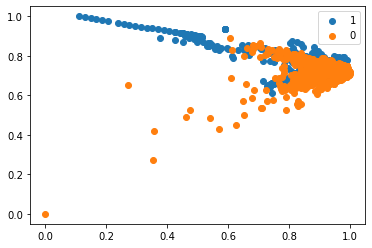

In [36]:
from imblearn.over_sampling import ADASYN

counter = Counter(y_train)
print(counter)
oversample = ADASYN(random_state = 42)
X, y = oversample.fit_resample(X_train, y_train)
counter = Counter(y)
print(counter)

for label, _ in counter.items():
    row_ix = where(y == label)[0]
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

**Construcción y evaluación del modelo ADASYN:**

In [37]:
# Inicialización del modelo
clf = IsolationForest(random_state=42)
clf.fit(X, y)
preds = clf.predict(X_test)

# Area under the curve
preds_scores = clf.score_samples(X_test)
preds = preds * -1
AUC_clf = roc_auc_score(y_test, preds_scores)
print('Area under the curve for the Isolation Forest:', AUC_clf)

# Evaluación del modelo
FALSE_NEGATIVE_PENALTY = 20

## Tenemos que convertir los -1 a 0 para poder comparar el accuracy del modelo entre y_test y las preds
preds[preds == -1] = 0

def weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):
    conf = confusion_matrix(y_test, preds)
    loss = conf[0][1] + conf[1][0] * FALSE_NEGATIVE_PENALTY
    maxloss = conf[0][0] + conf[0][1] + (conf[1][0] + conf[1][1]) * FALSE_NEGATIVE_PENALTY
    return (maxloss - loss) / maxloss * 100

print(f"Weighted accuracy = {weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):.3}%")

# Matriz de confusión
matriz_confusion = confusion_matrix(y_test, preds)
matriz_confusion = pd.DataFrame(matriz_confusion)
matriz_confusion

Area under the curve for the Isolation Forest: 0.07152357723577235
Weighted accuracy = 85.2%


,0,1
0,4814,186
1,64,182


Después de haber utilizado varios modelos oversampling y undersampling basados en la librería SMOTE, podemos observar que aquellos que funcionan mejor son los que no utilizan un pipeline para reducir la clase mayoritaria y aumentar la minoritaria. Pese a que en teoría esta técnica puede parecer una buena idea, en nuestro dataset, como los datos están muy juntos, tiende a hacer que empeore el modelo. 

Hemos probado dintintos clasificadores con distintos parámetros, los mejores han sido:
- SMOTE: El cuál hemos empleado como benchmar a la hora de comparar la performance de los otros clasificadores puesto que es el más simple de todos. Duplica la información minoritaria y no aumenta la nueva información en el modelo de ML. Se basa en k-nearest neighbor para conseguir que la cantidad de las clases sea la misma.
- Borderline SMOTE: Solo crea datos sintéticos a lo largo de la 'decision boundary' de las clases.
- ADASYN: Crea datos sintéticos a basandose en la densidad de los datos. Ha sido el mejor midelo, la 'weighted accuracy' es de un 82.5% y tiene un 'False Negative error'de un 35.16%.

## Supervised models

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
Let's check now whether we can improve the results using supervised models, that is, models that exploit the Class information available in the training data. Try <b>at least five</b> ensemble-based classification models, <b>using only the data in the training set</b>.
 </td></tr>
</table>

<table>
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">
Some suggestions on the scikit-learn models you can use are: Random Forest, Extra Trees, AdaBoost, Gradient Boosting,  Bagging, Voting and Stacking. You can also use an XGBClassifier, also included in this environment.
 </td></tr>
</table>

<table>
 <tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td style="text-align:left">
     Bonus points will we awarded for:
     <ul>
         <li>Trying more ensemble strategies beyond the minimum requirement of five.</li>
         <li>Improving the AUC score of your best model as much as possible.</li>
         <li>Trying <a href=https://catboost.ai/>CatBoost</a> and/or <a href=https://lightgbm.readthedocs.io/en/latest/>LightGBM</a>, other two popular ensemble methods. Note you will need to install these in your environment.</li>
     </ul>
 </td></tr>
</table>

Antes de proceder a correr los siguientes códigos, por favor aseguresé de que el último oversampler que ha corrido ha sido ADASYN. De no ser así no estaría utilizando el mejor de los modelos de oversampling evaluado para este dataset

### Random Forest Regresor

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier,VotingClassifier,StackingClassifier

Standard:

In [39]:
param_grid_random_forest = {'bootstrap': [True, False],
 'max_depth': [20, 40, 60, 80, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50, 100, 150, 200]}

random_forest = RandomForestClassifier()
grid_random_forest = RandomizedSearchCV(random_forest,param_grid_random_forest, cv = 3, n_iter = 50, scoring='roc_auc')
grid_random_forest.fit(X_train,y_train)
preds_scores = grid_random_forest.predict_proba(X_test)
preds = grid_random_forest.predict(X_test)

In [40]:
# Matriz de confusión
matriz_confusion = confusion_matrix(y_test, preds)
matriz_confusion = pd.DataFrame(matriz_confusion)
matriz_confusion

,0,1
0,5000,0
1,40,206


Area under the curve: 0.9806788617886179


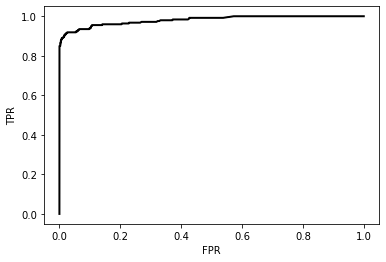

In [41]:
AUC_clf = roc_auc_score(y_test, preds_scores[:,1])
print('Area under the curve:', AUC_clf)
fpr, tpr, thresholds = roc_curve(y_test,preds_scores[:,1])
plt.plot(fpr, tpr, 'k-', lw=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [42]:
# Evaluación del modelo
FALSE_NEGATIVE_PENALTY = 20
def weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):
    conf = confusion_matrix(y_test, preds)
    loss = conf[0][1] + conf[1][0] * FALSE_NEGATIVE_PENALTY
    maxloss = conf[0][0] + conf[0][1] + (conf[1][0] + conf[1][1]) * FALSE_NEGATIVE_PENALTY
    return (maxloss - loss) / maxloss * 100

print(f"Weighted accuracy = {weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):.3}%")

Weighted accuracy = 91.9%


Oversampled:

In [43]:
param_grid_random_forest = {'bootstrap': [True, False],
 'max_depth': [20, 40, 60, 80, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50, 100, 150, 200]}

random_forest = RandomForestClassifier()
grid_random_forest = RandomizedSearchCV(random_forest,param_grid_random_forest, cv = 3, n_iter = 50, scoring='roc_auc')
grid_random_forest.fit(X,y)
preds_scores = grid_random_forest.predict_proba(X_test)
preds = grid_random_forest.predict(X_test)

In [44]:
# Matriz de confusión
matriz_confusion = confusion_matrix(y_test, preds)
matriz_confusion = pd.DataFrame(matriz_confusion)
matriz_confusion

,0,1
0,4998,2
1,56,190


Area under the curve: 0.9807333333333335


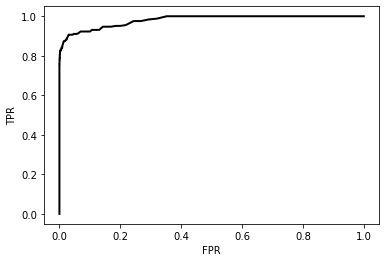

In [45]:
AUC_clf = roc_auc_score(y_test, preds_scores[:,1])
print('Area under the curve:', AUC_clf)
fpr, tpr, thresholds = roc_curve(y_test,preds_scores[:,1])
plt.plot(fpr, tpr, 'k-', lw=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [46]:
# Evaluación del modelo
FALSE_NEGATIVE_PENALTY = 20
def weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):
    conf = confusion_matrix(y_test, preds)
    loss = conf[0][1] + conf[1][0] * FALSE_NEGATIVE_PENALTY
    maxloss = conf[0][0] + conf[0][1] + (conf[1][0] + conf[1][1]) * FALSE_NEGATIVE_PENALTY
    return (maxloss - loss) / maxloss * 100

print(f"Weighted accuracy = {weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):.3}%")

Weighted accuracy = 88.7%


### Extra Trees

Standard:

In [47]:
param_grid_extra_trees = {'n_estimators': range(50,126,25),
        'min_samples_leaf': range(20,50,5),
        'min_samples_split': range(15,36,5)}

extra_trees = ExtraTreesClassifier()
grid_extra_trees = GridSearchCV(extra_trees,param_grid_extra_trees, cv = 3, scoring='roc_auc')
grid_extra_trees.fit(X_train,y_train)
preds_scores=grid_extra_trees.predict_proba(X_test)

In [48]:
preds = grid_extra_trees.predict(X_test)
# Matriz de confusión
matriz_confusion = confusion_matrix(y_test, preds)
matriz_confusion = pd.DataFrame(matriz_confusion)
matriz_confusion

,0,1
0,5000,0
1,123,123


Area under the curve: 0.9722902439024391


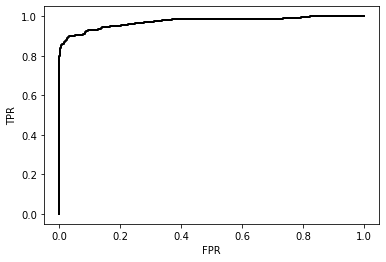

In [49]:
AUC_clf = roc_auc_score(y_test, preds_scores[:,1])
print('Area under the curve:', AUC_clf)
fpr, tpr, thresholds = roc_curve(y_test,preds_scores[:,1])
plt.plot(fpr, tpr, 'k-', lw=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [50]:
# Evaluación del modelo
FALSE_NEGATIVE_PENALTY = 20
def weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):
    conf = confusion_matrix(y_test, preds)
    loss = conf[0][1] + conf[1][0] * FALSE_NEGATIVE_PENALTY
    maxloss = conf[0][0] + conf[0][1] + (conf[1][0] + conf[1][1]) * FALSE_NEGATIVE_PENALTY
    return (maxloss - loss) / maxloss * 100

print(f"Weighted accuracy = {weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):.3}%")

Weighted accuracy = 75.2%


Oversampled:

In [51]:
param_grid_extra_trees = {'n_estimators': range(50,126,25),
        'min_samples_leaf': range(20,50,5),
        'min_samples_split': range(15,36,5)}

extra_trees = ExtraTreesClassifier()
grid_extra_trees = GridSearchCV(extra_trees,param_grid_extra_trees, cv = 3, scoring='roc_auc')
grid_extra_trees.fit(X,y)
preds_scores = grid_extra_trees.predict_proba(X_test)

In [52]:
preds = grid_extra_trees.predict(X_test)
# Matriz de confusión
matriz_confusion = confusion_matrix(y_test, preds)
matriz_confusion = pd.DataFrame(matriz_confusion)
matriz_confusion

,0,1
0,4812,188
1,28,218


Area under the curve: 0.9786861788617885


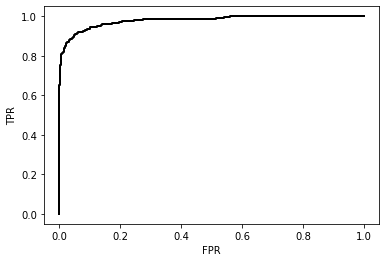

In [53]:
AUC_clf = roc_auc_score(y_test, preds_scores[:,1])
print('Area under the curve:', AUC_clf)
fpr, tpr, thresholds = roc_curve(y_test,preds_scores[:,1])
plt.plot(fpr, tpr, 'k-', lw=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [54]:
# Evaluación del modelo
FALSE_NEGATIVE_PENALTY = 20
def weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):
    conf = confusion_matrix(y_test, preds)
    loss = conf[0][1] + conf[1][0] * FALSE_NEGATIVE_PENALTY
    maxloss = conf[0][0] + conf[0][1] + (conf[1][0] + conf[1][1]) * FALSE_NEGATIVE_PENALTY
    return (maxloss - loss) / maxloss * 100

print(f"Weighted accuracy = {weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):.3}%")

Weighted accuracy = 92.5%


### Ada Boost

Standard:

In [55]:
param_grid_ada_boost = {'n_estimators':[100,500,100],'learning_rate':[.001,0.01,.1,0.5]}
ada_boost = AdaBoostClassifier()
grid_ada_boost = GridSearchCV(ada_boost,param_grid_ada_boost, cv = 3, scoring='roc_auc')
grid_ada_boost.fit(X_train,y_train)
preds_scores=grid_ada_boost.predict_proba(X_test)

In [56]:
preds = grid_ada_boost.predict(X_test)
# Matriz de confusión
matriz_confusion = confusion_matrix(y_test, preds)
matriz_confusion = pd.DataFrame(matriz_confusion)
matriz_confusion

,0,1
0,5000,0
1,48,198


Area under the curve: 0.9749573170731707


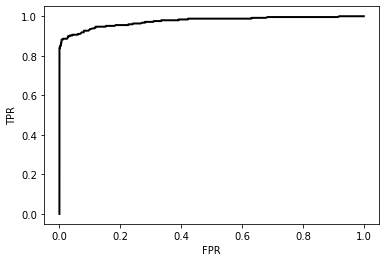

In [57]:
AUC_clf = roc_auc_score(y_test, preds_scores[:,1])
print('Area under the curve:', AUC_clf)
fpr, tpr, thresholds = roc_curve(y_test,preds_scores[:,1])
plt.plot(fpr, tpr, 'k-', lw=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [58]:
# Evaluación del modelo
FALSE_NEGATIVE_PENALTY = 20
def weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):
    conf = confusion_matrix(y_test, preds)
    loss = conf[0][1] + conf[1][0] * FALSE_NEGATIVE_PENALTY
    maxloss = conf[0][0] + conf[0][1] + (conf[1][0] + conf[1][1]) * FALSE_NEGATIVE_PENALTY
    return (maxloss - loss) / maxloss * 100

print(f"Weighted accuracy = {weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):.3}%")

Weighted accuracy = 90.3%


Oversampled:

In [59]:
param_grid_ada_boost = {'n_estimators':[100,500,100],'learning_rate':[.001,0.01,.1,0.5]}
ada_boost = AdaBoostClassifier()
grid_ada_boost = GridSearchCV(ada_boost,param_grid_ada_boost, cv = 3, scoring='roc_auc')
grid_ada_boost.fit(X,y)
preds_scores = grid_ada_boost.predict_proba(X_test)

In [60]:
preds = grid_ada_boost.predict(X_test)
# Matriz de confusión
matriz_confusion = confusion_matrix(y_test, preds)
matriz_confusion = pd.DataFrame(matriz_confusion)
matriz_confusion

,0,1
0,4801,199
1,38,208


Area under the curve: 0.9557227642276424


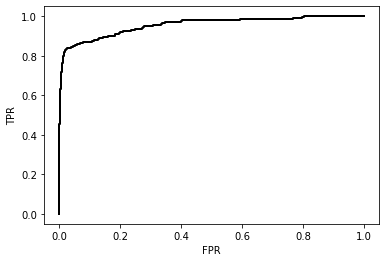

In [61]:
AUC_clf = roc_auc_score(y_test, preds_scores[:,1])
print('Area under the curve:', AUC_clf)
fpr, tpr, thresholds = roc_curve(y_test,preds_scores[:,1])
plt.plot(fpr, tpr, 'k-', lw=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [62]:
# Evaluación del modelo
FALSE_NEGATIVE_PENALTY = 20
def weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):
    conf = confusion_matrix(y_test, preds)
    loss = conf[0][1] + conf[1][0] * FALSE_NEGATIVE_PENALTY
    maxloss = conf[0][0] + conf[0][1] + (conf[1][0] + conf[1][1]) * FALSE_NEGATIVE_PENALTY
    return (maxloss - loss) / maxloss * 100

print(f"Weighted accuracy = {weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):.3}%")

Weighted accuracy = 90.3%


### Gradient Boosting

Standard:

In [63]:
param_grid_gradient_boosting = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mse"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    }    

gradient_boosting= GradientBoostingClassifier()
grid_gradient_boosting = RandomizedSearchCV(gradient_boosting,param_grid_gradient_boosting, cv = 2, scoring='roc_auc')
grid_gradient_boosting.fit(X_train,y_train)
preds_scores=grid_gradient_boosting.predict_proba(X_test)

In [64]:
preds = grid_gradient_boosting.predict(X_test)
# Matriz de confusión
matriz_confusion = confusion_matrix(y_test, preds)
matriz_confusion = pd.DataFrame(matriz_confusion)
matriz_confusion

,0,1
0,5000,0
1,246,0


Area under the curve: 0.9722065040650407


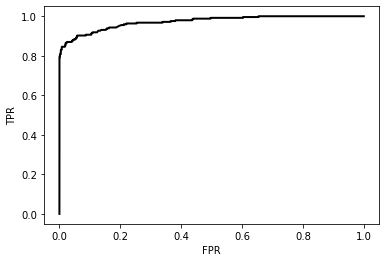

In [65]:
AUC_clf = roc_auc_score(y_test, preds_scores[:,1])
print('Area under the curve:', AUC_clf)
fpr, tpr, thresholds = roc_curve(y_test,preds_scores[:,1])
plt.plot(fpr, tpr, 'k-', lw=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [66]:
# Evaluación del modelo
FALSE_NEGATIVE_PENALTY = 20
def weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):
    conf = confusion_matrix(y_test, preds)
    loss = conf[0][1] + conf[1][0] * FALSE_NEGATIVE_PENALTY
    maxloss = conf[0][0] + conf[0][1] + (conf[1][0] + conf[1][1]) * FALSE_NEGATIVE_PENALTY
    return (maxloss - loss) / maxloss * 100

print(f"Weighted accuracy = {weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):.3}%")

Weighted accuracy = 50.4%


Oversampled:

In [67]:
param_grid_gradient_boosting = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mse"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    }    

gradient_boosting= GradientBoostingClassifier()
grid_gradient_boosting = RandomizedSearchCV(gradient_boosting,param_grid_gradient_boosting, cv = 2,scoring='roc_auc')
grid_gradient_boosting.fit(X,y)
preds_scores=grid_gradient_boosting.predict_proba(X_test)

In [68]:
preds = grid_gradient_boosting.predict(X_test)
# Matriz de confusión
matriz_confusion = confusion_matrix(y_test, preds)
matriz_confusion = pd.DataFrame(matriz_confusion)
matriz_confusion

,0,1
0,4388,612
1,20,226


Area under the curve: 0.9523491869918699


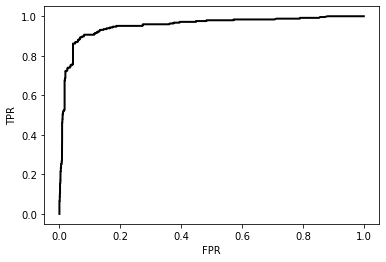

In [69]:
AUC_clf = roc_auc_score(y_test, preds_scores[:,1])
print('Area under the curve:', AUC_clf)
fpr, tpr, thresholds = roc_curve(y_test,preds_scores[:,1])
plt.plot(fpr, tpr, 'k-', lw=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [70]:
# Evaluación del modelo
FALSE_NEGATIVE_PENALTY = 20
def weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):
    conf = confusion_matrix(y_test, preds)
    loss = conf[0][1] + conf[1][0] * FALSE_NEGATIVE_PENALTY
    maxloss = conf[0][0] + conf[0][1] + (conf[1][0] + conf[1][1]) * FALSE_NEGATIVE_PENALTY
    return (maxloss - loss) / maxloss * 100

print(f"Weighted accuracy = {weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):.3}%")

Weighted accuracy = 89.8%


### Bagging

In [71]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression

Standard:

In [72]:
param_grid_Bagging = {
    'base_estimator': [None, LinearRegression(), KNeighborsRegressor()],
    'bootstrap': [True, False],
    'bootstrap_features': [False, True],
    'max_features': [0.5, 0.7, 1.0],
    'max_samples': [0.5, 0.7, 1.0],
    'n_estimators': [2, 5, 10, 20]
    } 

Bagging = BaggingClassifier()
grid_Baging = RandomizedSearchCV(Bagging,param_grid_Bagging, cv = 2,scoring='roc_auc')
grid_Baging.fit(X_train, y_train)
preds_scores=grid_Baging.predict_proba(X_test)

C:\Anaconda3\envs\ensembles-labs\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda3\envs\ensembles-labs\lib\site-packages\sklearn\metrics\_scorer.py", line 334, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Anaconda3\envs\ensembles-labs\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Anaconda3\envs\ensembles-labs\lib\site-packages\sklearn\utils\metaestimators.py", line 114, in __get__
    getattr(delegate, self.attribute_name)
AttributeError: 'KNeighborsRegressor' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\ensembles-labs\lib\site-packages\sklearn\model_se

In [73]:
preds = grid_Baging.predict(X_test)
# Matriz de confusión
matriz_confusion = confusion_matrix(y_test, preds)
matriz_confusion = pd.DataFrame(matriz_confusion)
matriz_confusion

,0,1
0,4997,3
1,44,202


Area under the curve: 0.9528804878048781


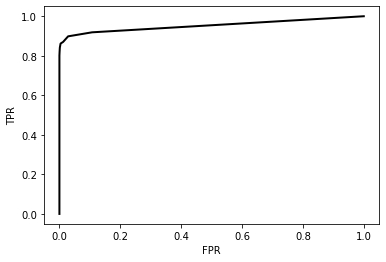

In [74]:
AUC_clf = roc_auc_score(y_test, preds_scores[:,1])
print('Area under the curve:', AUC_clf)
fpr, tpr, thresholds = roc_curve(y_test,preds_scores[:,1])
plt.plot(fpr, tpr, 'k-', lw=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [75]:
# Evaluación del modelo
FALSE_NEGATIVE_PENALTY = 20
def weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):
    conf = confusion_matrix(y_test, preds)
    loss = conf[0][1] + conf[1][0] * FALSE_NEGATIVE_PENALTY
    maxloss = conf[0][0] + conf[0][1] + (conf[1][0] + conf[1][1]) * FALSE_NEGATIVE_PENALTY
    return (maxloss - loss) / maxloss * 100

print(f"Weighted accuracy = {weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):.3}%")

Weighted accuracy = 91.1%


Oversampled:

In [76]:
param_grid_Bagging = {
    'base_estimator': [None, LinearRegression(), KNeighborsRegressor()],
    'bootstrap': [True, False],
    'bootstrap_features': [False, True],
    'max_features': [0.5, 0.7, 1.0],
    'max_samples': [0.5, 0.7, 1.0],
    'n_estimators': [2, 5, 10, 20]
    } 

Bagging = BaggingClassifier()
grid_Baging = RandomizedSearchCV(Bagging,param_grid_Bagging, cv = 2,scoring='roc_auc')
grid_Baging.fit(X, y)
preds_scores = grid_Baging.predict_proba(X_test)

C:\Anaconda3\envs\ensembles-labs\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda3\envs\ensembles-labs\lib\site-packages\sklearn\metrics\_scorer.py", line 334, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Anaconda3\envs\ensembles-labs\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Anaconda3\envs\ensembles-labs\lib\site-packages\sklearn\utils\metaestimators.py", line 114, in __get__
    getattr(delegate, self.attribute_name)
AttributeError: 'LinearRegression' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\ensembles-labs\lib\site-packages\sklearn\model_selec

In [77]:
preds = grid_Baging.predict(X_test)
# Matriz de confusión
matriz_confusion = confusion_matrix(y_test, preds)
matriz_confusion = pd.DataFrame(matriz_confusion)
matriz_confusion

,0,1
0,4997,3
1,61,185


Area under the curve: 0.9598833333333334


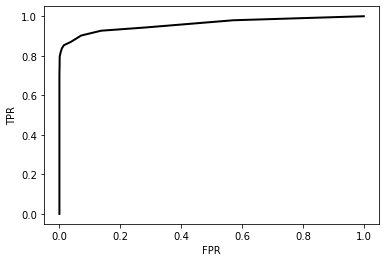

In [78]:
AUC_clf = roc_auc_score(y_test, preds_scores[:,1])
print('Area under the curve:', AUC_clf)
fpr, tpr, thresholds = roc_curve(y_test,preds_scores[:,1])
plt.plot(fpr, tpr, 'k-', lw=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [79]:
# Evaluación del modelo
FALSE_NEGATIVE_PENALTY = 20
def weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):
    conf = confusion_matrix(y_test, preds)
    loss = conf[0][1] + conf[1][0] * FALSE_NEGATIVE_PENALTY
    maxloss = conf[0][0] + conf[0][1] + (conf[1][0] + conf[1][1]) * FALSE_NEGATIVE_PENALTY
    return (maxloss - loss) / maxloss * 100

print(f"Weighted accuracy = {weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):.3}%")

Weighted accuracy = 87.7%


### CatBoost:

In [82]:
from catboost import CatBoostClassifier, Pool

Standard:

In [83]:
# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=2,
                           learning_rate=1,
                           depth=2)
# Fit model
model.fit(X_train, y_train)
# Get predicted classes
preds_class = model.predict(X_test)
# Get predicted probabilities for each class
preds_scores= model.predict_proba(X_test)
# Get predicted RawFormulaVal
preds_raw = model.predict(X_test)

0:	learn: 0.0650649	total: 146ms	remaining: 146ms
1:	learn: 0.0520417	total: 149ms	remaining: 0us


In [84]:
# Matriz de confusión
matriz_confusion = confusion_matrix(y_test, preds_raw)
matriz_confusion = pd.DataFrame(matriz_confusion)
matriz_confusion

,0,1
0,4995,5
1,76,170


Area under the curve: 0.9257520325203251


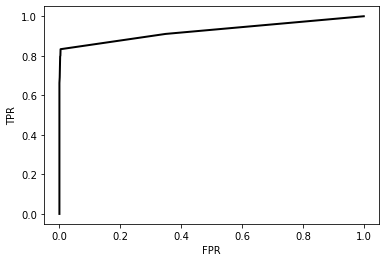

In [85]:
AUC_clf = roc_auc_score(y_test, preds_scores[:,1])
print('Area under the curve:', AUC_clf)
fpr, tpr, thresholds = roc_curve(y_test,preds_scores[:,1])
plt.plot(fpr, tpr, 'k-', lw=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [86]:
# Evaluación del modelo
FALSE_NEGATIVE_PENALTY = 20
def weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):
    conf = confusion_matrix(y_test, preds)
    loss = conf[0][1] + conf[1][0] * FALSE_NEGATIVE_PENALTY
    maxloss = conf[0][0] + conf[0][1] + (conf[1][0] + conf[1][1]) * FALSE_NEGATIVE_PENALTY
    return (maxloss - loss) / maxloss * 100

print(f"Weighted accuracy = {weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):.3}%")

Weighted accuracy = 87.7%


Oversampled:

In [87]:
# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=2,
                           learning_rate=1,
                           depth=2)
# Fit model
model.fit(X, y)
# Get predicted classes
preds_class = model.predict(X_test)
# Get predicted probabilities for each class
preds_scores = model.predict_proba(X_test)
# Get predicted RawFormulaVal
preds_raw = model.predict(X_test)

0:	learn: 0.4749918	total: 4.81ms	remaining: 4.81ms
1:	learn: 0.3860512	total: 9.21ms	remaining: 0us


In [88]:
# Matriz de confusión
matriz_confusion = confusion_matrix(y_test, preds_raw)
matriz_confusion = pd.DataFrame(matriz_confusion)
matriz_confusion

,0,1
0,3865,1135
1,28,218


Area under the curve: 0.8315573170731707


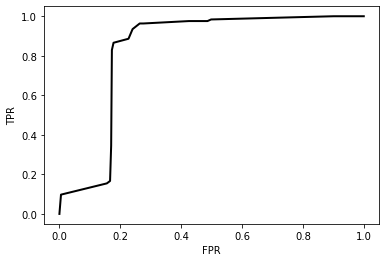

In [89]:
AUC_clf = roc_auc_score(y_test, preds_scores[:,1])
print('Area under the curve:', AUC_clf)
fpr, tpr, thresholds = roc_curve(y_test,preds_scores[:,1])
plt.plot(fpr, tpr, 'k-', lw=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [90]:
# Evaluación del modelo
FALSE_NEGATIVE_PENALTY = 20
def weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):
    conf = confusion_matrix(y_test, preds)
    loss = conf[0][1] + conf[1][0] * FALSE_NEGATIVE_PENALTY
    maxloss = conf[0][0] + conf[0][1] + (conf[1][0] + conf[1][1]) * FALSE_NEGATIVE_PENALTY
    return (maxloss - loss) / maxloss * 100

print(f"Weighted accuracy = {weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):.3}%")

Weighted accuracy = 87.7%


### Voting

In [91]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

Standard:

In [92]:
voting = VotingClassifier(estimators=[
   ('KN', KNeighborsClassifier()), ('SVC', SVC(probability=True)), ('Naive', GaussianNB()),], voting='soft')
voting.fit(X_train,y_train)
preds_scores = voting.predict_proba(X_test)
print(voting.estimators_)

[KNeighborsClassifier(), SVC(probability=True), GaussianNB()]


In [93]:
preds = voting.predict(X_test)
# Matriz de confusión
matriz_confusion = confusion_matrix(y_test, preds)
matriz_confusion = pd.DataFrame(matriz_confusion)
matriz_confusion

,0,1
0,5000,0
1,52,194


Area under the curve: 0.9751081300813007


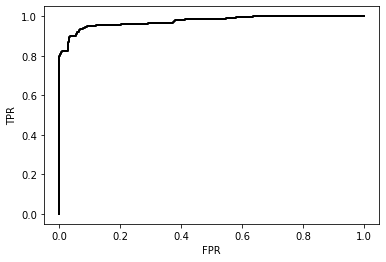

In [94]:
AUC_clf = roc_auc_score(y_test, preds_scores[:,1])
print('Area under the curve:', AUC_clf)
fpr, tpr, thresholds = roc_curve(y_test,preds_scores[:,1])
plt.plot(fpr, tpr, 'k-', lw=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [95]:
# Evaluación del modelo
FALSE_NEGATIVE_PENALTY = 20
def weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):
    conf = confusion_matrix(y_test, preds)
    loss = conf[0][1] + conf[1][0] * FALSE_NEGATIVE_PENALTY
    maxloss = conf[0][0] + conf[0][1] + (conf[1][0] + conf[1][1]) * FALSE_NEGATIVE_PENALTY
    return (maxloss - loss) / maxloss * 100

print(f"Weighted accuracy = {weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):.3}%")

Weighted accuracy = 89.5%


Oversampled:

In [96]:
voting = VotingClassifier(estimators=[
   ('KN', KNeighborsClassifier()), ('SVC', SVC(probability=True)), ('Naive', GaussianNB()),], voting='soft')
voting.fit(X,y)
preds_scores = voting.predict_proba(X_test)

In [97]:
preds = voting.predict(X_test)
# Matriz de confusión
matriz_confusion = confusion_matrix(y_test, preds)
matriz_confusion = pd.DataFrame(matriz_confusion)
matriz_confusion

,0,1
0,4745,255
1,20,226


Area under the curve: 0.9694878048780488


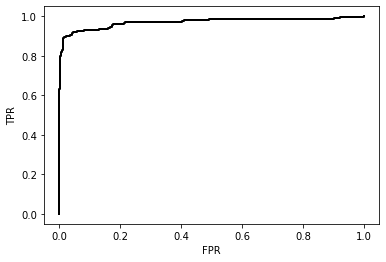

In [98]:
AUC_clf = roc_auc_score(y_test, preds_scores[:,1])
print('Area under the curve:', AUC_clf)
fpr, tpr, thresholds = roc_curve(y_test,preds_scores[:,1])
plt.plot(fpr, tpr, 'k-', lw=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [99]:
# Evaluación del modelo
FALSE_NEGATIVE_PENALTY = 20
def weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):
    conf = confusion_matrix(y_test, preds)
    loss = conf[0][1] + conf[1][0] * FALSE_NEGATIVE_PENALTY
    maxloss = conf[0][0] + conf[0][1] + (conf[1][0] + conf[1][1]) * FALSE_NEGATIVE_PENALTY
    return (maxloss - loss) / maxloss * 100

print(f"Weighted accuracy = {weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):.3}%")

Weighted accuracy = 93.4%


### XGBClassifier

Standard:

In [100]:
from xgboost import XGBClassifier

In [101]:
xgb = XGBClassifier(use_label_encoder=False)
param_grid_xgb = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
grid_xgb = RandomizedSearchCV(xgb,param_grid_xgb, cv = 2,scoring='roc_auc')
grid_xgb.fit(X_train, y_train)
preds_scores = grid_xgb.predict_proba(X_test)

In [102]:
preds = grid_xgb.predict(X_test)
# Matriz de confusión
matriz_confusion = confusion_matrix(y_test, preds)
matriz_confusion = pd.DataFrame(matriz_confusion)
matriz_confusion

,0,1
0,4996,4
1,45,201


Area under the curve: 0.9740056910569105


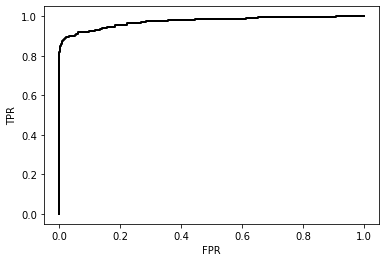

In [103]:
AUC_clf = roc_auc_score(y_test, preds_scores[:,1])
print('Area under the curve:', AUC_clf)
fpr, tpr, thresholds = roc_curve(y_test,preds_scores[:,1])
plt.plot(fpr, tpr, 'k-', lw=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [104]:
# Evaluación del modelo
FALSE_NEGATIVE_PENALTY = 20
def weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):
    conf = confusion_matrix(y_test, preds)
    loss = conf[0][1] + conf[1][0] * FALSE_NEGATIVE_PENALTY
    maxloss = conf[0][0] + conf[0][1] + (conf[1][0] + conf[1][1]) * FALSE_NEGATIVE_PENALTY
    return (maxloss - loss) / maxloss * 100

print(f"Weighted accuracy = {weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):.3}%")

Weighted accuracy = 90.9%


Oversampled:

In [105]:
xgb = XGBClassifier(use_label_encoder=False)
grid_xgb = RandomizedSearchCV(xgb,param_grid_xgb, cv = 2,scoring='roc_auc')
grid_xgb.fit(X, y)
preds_scores = grid_xgb.predict_proba(X_test)

In [106]:
preds = grid_xgb.predict(X_test)
# Matriz de confusión
matriz_confusion = confusion_matrix(y_test, preds)
matriz_confusion = pd.DataFrame(matriz_confusion)
matriz_confusion

,0,1
0,4950,50
1,44,202


Area under the curve: 0.972361788617886


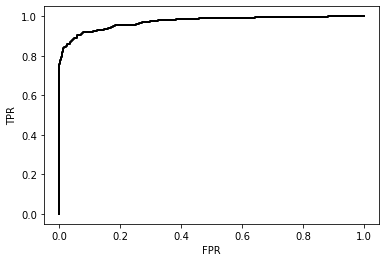

In [107]:
AUC_clf = roc_auc_score(y_test, preds_scores[:,1])
print('Area under the curve:', AUC_clf)
fpr, tpr, thresholds = roc_curve(y_test,preds_scores[:,1])
plt.plot(fpr, tpr, 'k-', lw=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [108]:
# Evaluación del modelo
FALSE_NEGATIVE_PENALTY = 20
def weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):
    conf = confusion_matrix(y_test, preds)
    loss = conf[0][1] + conf[1][0] * FALSE_NEGATIVE_PENALTY
    maxloss = conf[0][0] + conf[0][1] + (conf[1][0] + conf[1][1]) * FALSE_NEGATIVE_PENALTY
    return (maxloss - loss) / maxloss * 100

print(f"Weighted accuracy = {weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):.3}%")

Weighted accuracy = 90.6%


### LightGBM

In [109]:
import lightgbm as lgb

Standard:

In [110]:
param_grid_lightgbm = {
    'num_leaves': [31, 127],
    'reg_alpha': [0.1, 0.5],
    'reg_lambda':[0, 1, 1.5],

    }
light = lgb.LGBMClassifier()
light_grid = RandomizedSearchCV(light,param_grid_lightgbm, cv = 2,scoring='roc_auc')

light_grid.fit(X_train,y_train)
preds_score = light_grid.predict_proba(X_test)

In [111]:
preds = light_grid.predict(X_test)
# Matriz de confusión
matriz_confusion = confusion_matrix(y_test, preds)
matriz_confusion = pd.DataFrame(matriz_confusion)
matriz_confusion

,0,1
0,4999,1
1,41,205


Area under the curve: 0.972361788617886


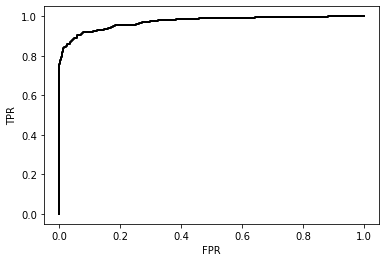

In [112]:
AUC_clf = roc_auc_score(y_test, preds_scores[:,1])
print('Area under the curve:', AUC_clf)
fpr, tpr, thresholds = roc_curve(y_test,preds_scores[:,1])
plt.plot(fpr, tpr, 'k-', lw=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [113]:
# Evaluación del modelo
FALSE_NEGATIVE_PENALTY = 20
def weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):
    conf = confusion_matrix(y_test, preds)
    loss = conf[0][1] + conf[1][0] * FALSE_NEGATIVE_PENALTY
    maxloss = conf[0][0] + conf[0][1] + (conf[1][0] + conf[1][1]) * FALSE_NEGATIVE_PENALTY
    return (maxloss - loss) / maxloss * 100

print(f"Weighted accuracy = {weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):.3}%")

Weighted accuracy = 91.7%


Oversampled:

In [114]:
light = lgb.LGBMClassifier()
light_grid = RandomizedSearchCV(light,param_grid_lightgbm, cv = 2,scoring='roc_auc')

light_grid.fit(X,y)
preds_score = light_grid.predict_proba(X_test)

In [115]:
preds = light_grid.predict(X_test)
# Matriz de confusión
matriz_confusion = confusion_matrix(y_test, preds)
matriz_confusion = pd.DataFrame(matriz_confusion)
matriz_confusion

,0,1
0,4970,30
1,45,201


Area under the curve: 0.972361788617886


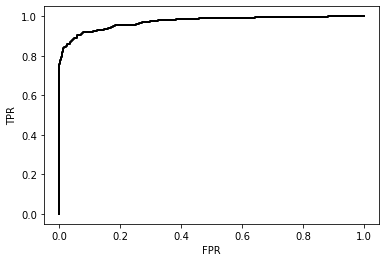

In [116]:
AUC_clf = roc_auc_score(y_test, preds_scores[:,1])
print('Area under the curve:', AUC_clf)
fpr, tpr, thresholds = roc_curve(y_test,preds_scores[:,1])
plt.plot(fpr, tpr, 'k-', lw=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [117]:
# Evaluación del modelo
FALSE_NEGATIVE_PENALTY = 20
def weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):
    conf = confusion_matrix(y_test, preds)
    loss = conf[0][1] + conf[1][0] * FALSE_NEGATIVE_PENALTY
    maxloss = conf[0][0] + conf[0][1] + (conf[1][0] + conf[1][1]) * FALSE_NEGATIVE_PENALTY
    return (maxloss - loss) / maxloss * 100

print(f"Weighted accuracy = {weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):.3}%")

Weighted accuracy = 90.6%


### Stacking

Standard:

Escojemos algunos de los mejores ensembles para combinarlos en Staking

In [118]:
 estimators = [
    ('ada', grid_ada_boost),
    ('Voting_O', voting),
    ('Bagging', grid_Baging),
    ('Extra_Trees_O', grid_extra_trees)]
stacking = StackingClassifier(
    estimators=estimators, final_estimator=RandomForestClassifier())

stacking.fit(X_train,y_train)
preds_score = stacking.predict_proba(X_test)

C:\Anaconda3\envs\ensembles-labs\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda3\envs\ensembles-labs\lib\site-packages\sklearn\metrics\_scorer.py", line 334, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Anaconda3\envs\ensembles-labs\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Anaconda3\envs\ensembles-labs\lib\site-packages\sklearn\utils\metaestimators.py", line 114, in __get__
    getattr(delegate, self.attribute_name)
AttributeError: 'LinearRegression' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\ensembles-labs\lib\site-packages\sklearn\model_selec

In [119]:
preds = stacking.predict(X_test)
# Matriz de confusión
matriz_confusion = confusion_matrix(y_test, preds)
matriz_confusion = pd.DataFrame(matriz_confusion)
matriz_confusion

,0,1
0,4995,5
1,43,203


Area under the curve: 0.972361788617886


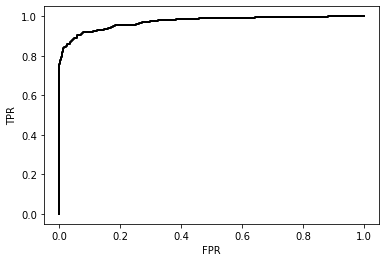

In [120]:
AUC_clf = roc_auc_score(y_test, preds_scores[:,1])
print('Area under the curve:', AUC_clf)
fpr, tpr, thresholds = roc_curve(y_test,preds_scores[:,1])
plt.plot(fpr, tpr, 'k-', lw=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [121]:
# Evaluación del modelo
FALSE_NEGATIVE_PENALTY = 20
def weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):
    conf = confusion_matrix(y_test, preds)
    loss = conf[0][1] + conf[1][0] * FALSE_NEGATIVE_PENALTY
    maxloss = conf[0][0] + conf[0][1] + (conf[1][0] + conf[1][1]) * FALSE_NEGATIVE_PENALTY
    return (maxloss - loss) / maxloss * 100

print(f"Weighted accuracy = {weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):.3}%")

Weighted accuracy = 91.3%


Oversampled:

In [126]:
 estimators = [
    ('ada', grid_ada_boost),
    ('Voting_O', voting),
    ('Bagging', grid_Baging),
    ('Extra_Trees_O', grid_extra_trees)]
stacking = StackingClassifier(
    estimators=estimators, final_estimator=RandomForestClassifier())
stacking.fit(X,y)
preds_score = stacking.predict_proba(X_test)

C:\Anaconda3\envs\ensembles-labs\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda3\envs\ensembles-labs\lib\site-packages\sklearn\metrics\_scorer.py", line 334, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "C:\Anaconda3\envs\ensembles-labs\lib\site-packages\sklearn\metrics\_scorer.py", line 53, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Anaconda3\envs\ensembles-labs\lib\site-packages\sklearn\utils\metaestimators.py", line 114, in __get__
    getattr(delegate, self.attribute_name)
AttributeError: 'KNeighborsRegressor' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Anaconda3\envs\ensembles-labs\lib\site-packages\sklearn\model_se

In [127]:
preds = stacking.predict(X_test)
# Matriz de confusión
matriz_confusion = confusion_matrix(y_test, preds)
matriz_confusion = pd.DataFrame(matriz_confusion)
matriz_confusion

,0,1
0,4767,233
1,52,194


Area under the curve: 0.972361788617886


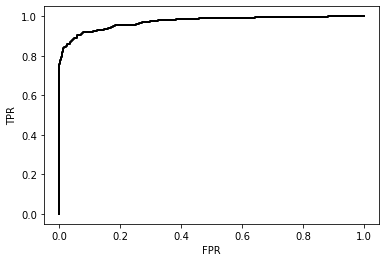

In [128]:
AUC_clf = roc_auc_score(y_test, preds_scores[:,1])
print('Area under the curve:', AUC_clf)
fpr, tpr, thresholds = roc_curve(y_test,preds_scores[:,1])
plt.plot(fpr, tpr, 'k-', lw=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [129]:
# Evaluación del modelo
FALSE_NEGATIVE_PENALTY = 20
def weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):
    conf = confusion_matrix(y_test, preds)
    loss = conf[0][1] + conf[1][0] * FALSE_NEGATIVE_PENALTY
    maxloss = conf[0][0] + conf[0][1] + (conf[1][0] + conf[1][1]) * FALSE_NEGATIVE_PENALTY
    return (maxloss - loss) / maxloss * 100

print(f"Weighted accuracy = {weighted_accuracy(y_test, preds, FALSE_NEGATIVE_PENALTY):.3}%")

Weighted accuracy = 87.2%


<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
Now create a visualization showing the performance of your supervised models on the test set, together with the unsupervised model. Has the performance improved after making use of the Class data? Which model obtains the best AUC?
 </td></tr>
</table>

After evaluating all the models we have used, we can confidently say that the ensembles with the best AUC have been:
- Random Forest
- Voting
- Ada Boost

This would be enough if a false negative and a false positive were equaly important. In this case, it is worse to have a false negative, as saying that a fraudulent activity is non fraudulent is much worse than saying the oposite. This is the reason why we crated a weighted accuracy metric were we stablished that a false negative is x20 times worse than a false positive. 

After having taken the above statement into consideration, we arrive to the conclusion that the best ensembles were:
- Voting Oversampled
- Extra Trees Oversampled
- Bagging Standard
- Ada Boost (Standard or Oversampled)

If we had avoided to compute a weighted accuracy metric, we might come to the conlusion that the Standard Extra Trees is a very good ensemble as it has a 0.9722 AUC score, when the reality is that it's False Negative predictive capabilities are not among the best. 

We have left the Staking ensemble at the end because in order the create it we first need to know which are the best models. The staking idea comes from knowing that is it difficult to have a model that will outperform the rest consistently, but the 5 best models will be consistently better than the rest. Therefore, if we stack these 5 models, we obtain a very consistent model.

Additionally, we would like to add that taking the time to 'modify' the training set with oversampling techniques such as ADYSA or SMOTE makes a difference when training ensembles, as it improves quite a lot its predictive capabilities.